In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# 원본데이터셋에서 무작위 샘플링
#data = pd.read_csv(r'C:\Users\302-t\Downloads\new-york-city-taxi-fare-prediction\train.csv')
#data_sampled = data.sample(frac=0.01)  # 원본의 1% 샘플링 => 약 50만 관측치

#data_sampled.to_csv('sampled_train.csv', index=False)

## 5만 관측치로 일단 수행

In [7]:
df = pd.read_csv('./train.csv')
print(len(df))
df.head()

50000


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [9]:
# 거리계산(하버사인)
def calc_haversine(lat1, lon1, lat2, lon2, unit='km'):
     R = 6371  # Radius of the Earth in kilometers
     d_lat = np.radians(lat2 - lat1)
     d_lon = np.radians(lon2 - lon1)
    
     a = (np.sin(d_lat / 2) ** 2 + 
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * 
         np.sin(d_lon / 2) ** 2)
     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
     
     dist = R * c  # Distance in kilometers

     if unit == 'miles':
          return dist * 0.621371  # Convert to miles
    
     return dist

In [10]:
# 거리 계산(picup 위도, 경도 drop 위도, 경도, 마일/킬로)
df['distance'] = calc_haversine(df['pickup_latitude'], df['pickup_longitude'], 
                                 df['dropoff_latitude'], df['dropoff_longitude'], unit='miles')

In [11]:
# km 검증
val_km = calc_haversine(40.721319, -73.844311, 40.721319, -73.84161)
print(val_km)

# miles 검증
val_miles = calc_haversine(40.721319, -73.844311, 40.721319, -73.84161, unit='miles')
print(val_miles)

val_miles2 = calc_haversine(40.721319, -73.844311, 40.712278, -73.841610, unit='miles')    
print(val_miles2)

0.22762328001256715
0.14143850512468886
0.6404868170854897


In [12]:
df2 = df.copy()

In [13]:
df2[['fare_amount', 'distance']].head(20)

,fare_amount,distance
0,4.5,0.640487
1,16.9,5.250668
2,5.7,0.863411
3,7.7,1.739385
4,5.3,1.242218
5,12.1,2.353281
6,7.5,0.966733
7,16.5,2.582073
8,9.0,0.778722
9,8.9,1.770675


In [14]:
df2.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840,11.500923
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195,220.937351
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000,0.760027
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000,1.317377
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000,2.420594
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000,5385.931243


In [15]:
# 리스트를 입력으로 받아서 해당 리스트 내에 음수값이 있으면 그 위치(인덱스)들을 리스트로 출력하는 함수를 만듭니다.  
def get_negative_index(list_data):
    neg_idx=[]
    
    for i, value in enumerate(list_data):
        if value < 0:
            neg_idx.append(list_data.index[i])         

    return neg_idx

# DataFrame 내에 제거해야 하는 이상치의 인덱스를 반환하는 함수를 만듭니다.
def outlier_index():
    # get_negative_index() 함수를 통해서, fare_amount와 passenger_count 내의 음수값들의 인덱스를 반환합니다.
    idx_fare_amount = get_negative_index(fare_amount)
    idx_passenger_count = get_negative_index(passenger_count)

    idx_zero_distance=[]    
    idx= [i for i in range(len(passenger_count))]
    zipped = zip(idx, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude)
   
    for i, x, y, _x, _y in zipped:
        # 타는 곳(pickup_longitude,pickup_latitude)과 내리는 곳(drop_longitude, drop_latitude)이 같은 데이터의 인덱스를 idx_zero_distance에 저장합니다.
        if (x == _x) and (y == _y):
            idx_zero_distance.append(i)
           
    total_index4remove = list(set(idx_fare_amount+idx_passenger_count+idx_zero_distance))
  
    return total_index4remove

# 인덱스를 기반으로 DataFrame 내의 데이터를 제거하고, 제거된 DataFrame을 반환하는 함수를 만듭니다.
def remove_outlier(dataframe, list_idx):
    return dataframe.drop(list_idx)

In [24]:
#불러온 DataFrame의 각 인덱스의 값들을 변수로 저장합니다.
fare_amount = df2['fare_amount']
passenger_count = df2['passenger_count']
pickup_longitude = df2['pickup_longitude']
pickup_latitude = df2['pickup_latitude']
dropoff_longitude = df2['dropoff_longitude']
dropoff_latitude = df2['dropoff_latitude']

# 이상치를 제거합니다.
remove_index = outlier_index()
df2=remove_outlier(df2, remove_index)
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 48545 entries, 0 to 49998
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                48545 non-null  object 
 1   fare_amount        48545 non-null  float64
 2   pickup_datetime    48545 non-null  object 
 3   pickup_longitude   48545 non-null  float64
 4   pickup_latitude    48545 non-null  float64
 5   dropoff_longitude  48545 non-null  float64
 6   dropoff_latitude   48545 non-null  float64
 7   passenger_count    48545 non-null  int64  
 8   distance           48545 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.7+ MB
None


In [25]:
df2.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,48545.000000,48545.000000,48545.000000,48545.000000,48545.000000,48545.000000,48545.000000
mean,11.367039,-73.858923,40.676481,-73.855149,40.669585,1.670347,11.734923
std,9.561261,3.230172,3.053760,3.260315,2.579533,1.291735,222.890446
min,0.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000,0.000052
25%,6.000000,-73.992300,40.736422,-73.991325,40.735770,1.000000,0.801429
50%,8.500000,-73.982125,40.753387,-73.980477,40.754057,1.000000,1.361472
75%,12.500000,-73.968423,40.767740,-73.965335,40.768482,2.000000,2.480455
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000,5385.931243


In [26]:
_mean = 12
_std = 223
# 이상값 탐지 기준 설정 (평균 ± 2 * 표준편차)
threshold_high = _mean + 2 * _std
threshold_low = _mean - 2 * _std

# 이상값 찾기
outliers = df2[(df2['distance'] > threshold_high) | (df2['distance'] < threshold_low)]
len(outliers)

92

In [27]:
# 이상값 제거
cleaned_data = df2[(df2['distance'] <= threshold_high) & (df2['distance'] >= threshold_low)]

In [28]:
cleaned_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,48453.000000,48453.000000,48453.000000,48453.000000,48453.000000,48453.000000,48453.000000
mean,11.363958,-73.927381,40.711650,-73.926205,40.704793,1.670671,2.131578
std,9.555967,2.320882,2.812289,2.320935,2.286681,1.291894,2.904474
min,0.000000,-75.423848,-74.006893,-75.354559,-74.006377,0.000000,0.000052
25%,6.000000,-73.992313,40.736490,-73.991333,40.735867,1.000000,0.800485
50%,8.500000,-73.982133,40.753432,-73.980496,40.754125,1.000000,1.358902
75%,12.500000,-73.968480,40.767781,-73.965426,40.768517,2.000000,2.469837
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000,233.912339


In [29]:
# df.corr()을 사용하여 상관 관계 값 계산
corr_df = cleaned_data.corr(numeric_only=True)
corr_df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
fare_amount,1.000000,0.017207,-0.012674,0.015604,-0.012657,0.018233,0.680655
pickup_longitude,0.017207,1.000000,-0.809468,0.999792,-0.995498,0.008482,0.010570
pickup_latitude,-0.012674,-0.809468,1.000000,-0.809481,0.813052,-0.008210,0.012004
dropoff_longitude,0.015604,0.999792,-0.809481,1.000000,-0.995511,0.008382,0.007400
dropoff_latitude,-0.012657,-0.995498,0.813052,-0.995511,1.000000,-0.008518,-0.004290
passenger_count,0.018233,0.008482,-0.008210,0.008382,-0.008518,1.000000,0.006525
distance,0.680655,0.010570,0.012004,0.007400,-0.004290,0.006525,1.000000


<Axes: xlabel='distance', ylabel='fare_amount'>

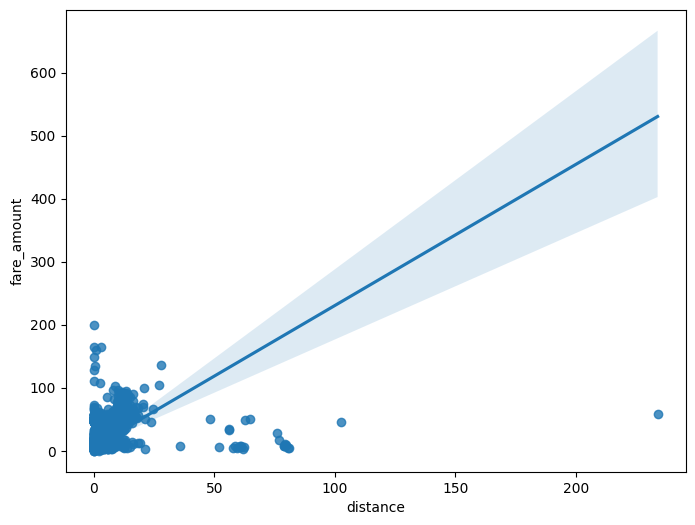

In [22]:
plt.figure(figsize=(8, 6))
sns.regplot(data=cleaned_data, x=cleaned_data['distance'], y=cleaned_data['fare_amount'], scatter=True)

# 회귀분석

In [ ]:
X = cleaned_data['distance'].values
Y = cleaned_data['fare_amount'].values
print(X.shape, Y.shape)
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
print(X.shape, Y.shape)

(48453,) (48453,)
(48453, 1) (48453, 1)


In [ ]:
# 회귀분석하기
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X, Y) # 학습

# r 계수
print (lr.coef_[0]) # 기울기

# y 절편
print (lr.intercept_) # y 절편

[2.23941325]
[6.59047415]


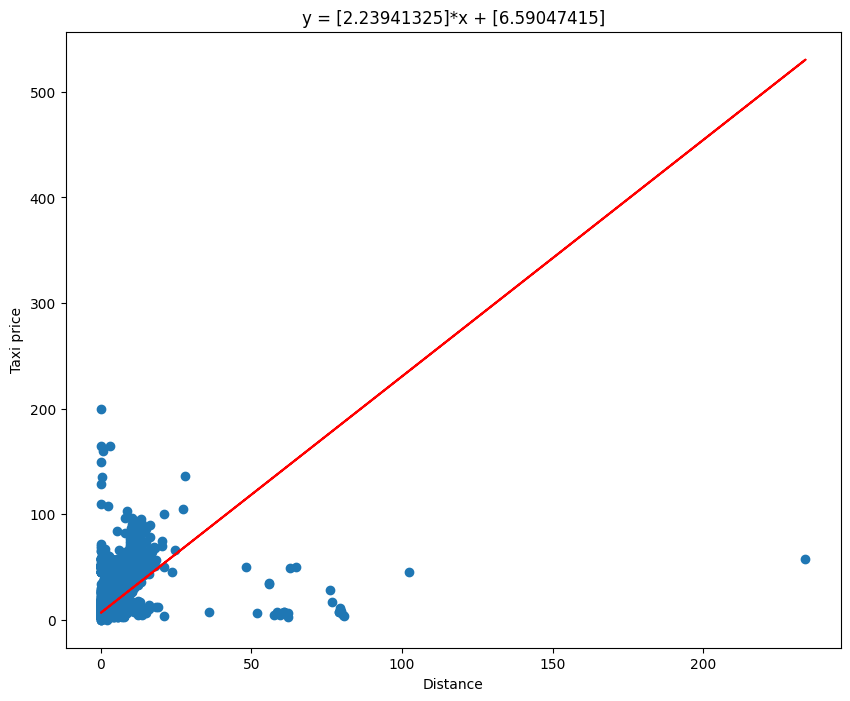

In [34]:
NewY = lr.coef_[0]*X + lr.intercept_ # Newy = (X * 기울기) + y절편  => 예측값

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(X, Y)
ax.set_xlabel('Distance')
ax.set_ylabel('Taxi price')

plt.plot(X, NewY, color='red') # 실제값하고 예측값하고 비교하기 위해
plt.title('y = {}*x + {}'.format(lr.coef_[0], lr.intercept_))
plt.show()

In [35]:
#pip install statsmodels
import statsmodels.api as sm
pd.set_option('display.notebook_repr_html', False)

res = sm.OLS(Y, sm.add_constant(X)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                 4.182e+04
Date:                    수, 19 3 2025   Prob (F-statistic):               0.00
Time:                        09:19:08   Log-Likelihood:            -1.6304e+05
No. Observations:               48453   AIC:                         3.261e+05
Df Residuals:                   48451   BIC:                         3.261e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5905      0.039    167.057      0.000       6.513       6.668
x1             2.2394      0.011    204.508      0.000       2.218       2.261
==============================================================================
Omnibus:                    71927.641   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        693414401.814
Skew:                          -7.937   Prob(JB):                         0.00
Kurtosis:                     588.844   Cond. No.                         4.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 예측값 구해보기(마일 x 기울기 + y절편)
5 * 2.23941325 + 6.59047415

17.7875404